# Import

In [4]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import pickle, json
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from utils import *
from datas import *
from Transformers import Transformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

stock = "2884.TW"
short = False

def predict(test = True, model_type="best", epoch=None):
    
    MODEL = "Transformer"
    if model_type == "best":
        model = Transformer(test=True)
        model.load_state_dict(torch.load(f'result/{MODEL}_{stock}_best.pt'))
        model.to("cpu")
    else:
        assert epoch != None, "Need epoch checkpoint"
        assert epoch % 10 == 0, "Epoch must be multiple of 10"
        model = Transformer(test=True)
        model.load_state_dict(torch.load(f'result/ckpt-{MODEL}_{stock}_{epoch}.pt'))
        model.to("cpu")
    
    loader = corp.testloader if test else corp.trainloader
    
    with torch.no_grad():
        model.eval()
        for x_test, y_test in loader:
            # testloader number of batch = 1
            _, result = model(src=corp.src, tgt=x_test, train=True) # train, test set train = True, valid set False
            result = result[:, -1, -1].cpu().numpy()
            truth = y_test[:, -1, -1].cpu().numpy()
            
    return result, truth

def backtest(result, truth, thres: int = 0, short: bool = False):
    
    asset = 1
    asset_buyhold = 1
    asset_hist = []
    asset_buyhold_hist = []
    
    for doc_1, pred in zip(truth, result):
        
        if pred > thres:
            asset *= (1 + doc_1/100)
        
        if short and pred < thres:
            asset *= (1 - doc_1/100)
                
        asset_hist.append(asset)
        asset_buyhold *= (1 + doc_1/100)
        asset_buyhold_hist.append(asset_buyhold)
        
    return asset_hist, asset_buyhold_hist

def getTimeTest(len_test):
    return corp.data.index[-len_test:]

corp = Data(stock)
corp.prepareData()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Shape:
            x_train: torch.Size([1960, 10, 6]), 
            x_valid: torch.Size([103, 10, 6]),
            x_test: torch.Size([109, 10, 6]),
            y_train: torch.Size([1960, 10, 6]),
            y_valid: torch.Size([103, 10, 6]),
            y_test: torch.Size([109, 10, 6])


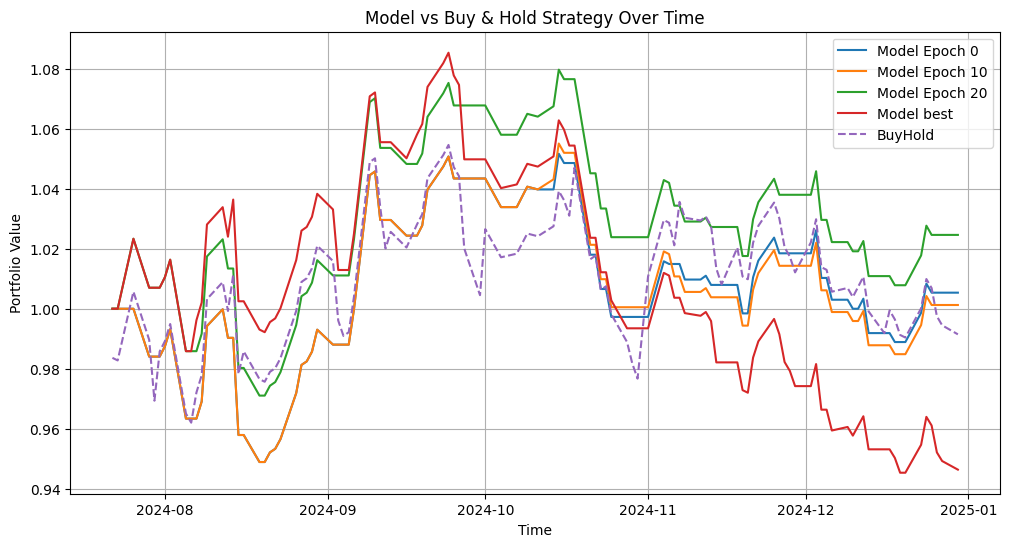

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))  # Set figure size

def evalPlot(epoch = None):
    # Plot best
    if epoch == None:
        result, truth = predict()
        
        result_val, _ = predict(test=False)
        thres = result_val.mean()
        
        asset_hist, asset_buyhold_hist = backtest(result, truth, 0)
        time = getTimeTest(result.shape[0])
        df = pd.DataFrame({"Model": asset_hist, "BuyHold": asset_buyhold_hist}).set_index(time)

        plt.plot(df["Model"], label=f"Model best")   # Model performance
        plt.plot(df["BuyHold"], linestyle="dashed", label=f"BuyHold")  # Buy & Hold strategy
    
    else:
        
        result_val, _ = predict(test=False, model_type="checkpoint", epoch=epoch)
        result, truth = predict(model_type="checkpoint", epoch=epoch)
        
    
        thres = result_val.mean()
        asset_hist, asset_buyhold_hist = backtest(result, truth, thres)
        time = getTimeTest(result.shape[0])
        df = pd.DataFrame({"Model": asset_hist, "BuyHold": asset_buyhold_hist}).set_index(time)

        plt.plot(df["Model"], label=f"Model Epoch {epoch}")   # Model performance    

for epoch in [0, 10, 20,  ]:  # Loop over epochs
    evalPlot(epoch)
    
evalPlot()

# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title("Model vs Buy & Hold Strategy Over Time")
plt.legend()
plt.grid(True)
plt.show()


### Use short

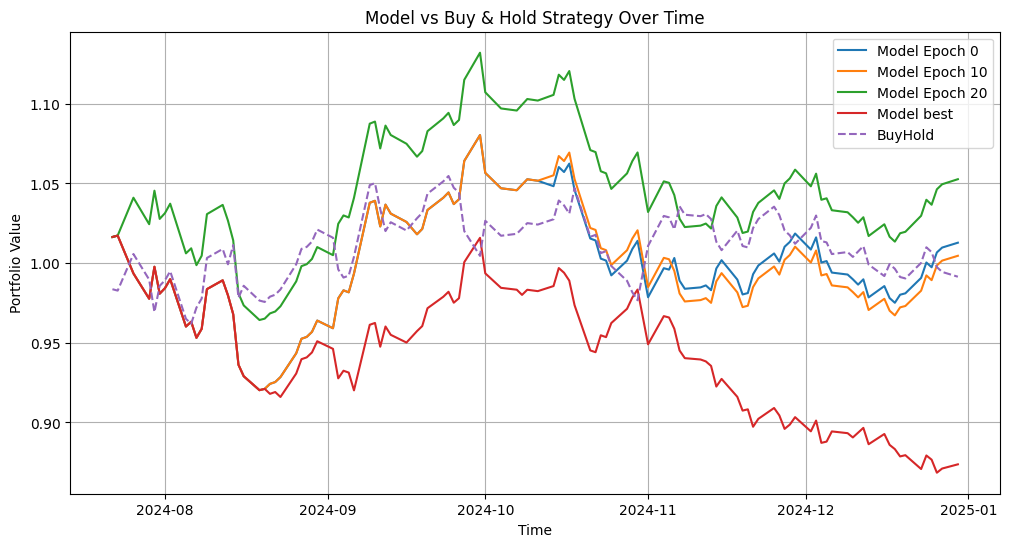

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))  # Set figure size

def evalPlot(epoch = None):
    # Plot best
    if epoch == None:
        result, truth = predict()
        
        result_val, _ = predict(test=False)
        thres = result_val.mean()
        
        asset_hist, asset_buyhold_hist = backtest(result, truth, thres, True)
        time = getTimeTest(result.shape[0])
        df = pd.DataFrame({"Model": asset_hist, "BuyHold": asset_buyhold_hist}).set_index(time)

        plt.plot(df["Model"], label=f"Model best")   # Model performance
        plt.plot(df["BuyHold"], linestyle="dashed", label=f"BuyHold")  # Buy & Hold strategy
    
    else:
        
        result_val, _ = predict(test=False, model_type="checkpoint", epoch=epoch)
        result, truth = predict(model_type="checkpoint", epoch=epoch)
        
    
        thres = result_val.mean()
        asset_hist, asset_buyhold_hist = backtest(result, truth, thres, True)
        time = getTimeTest(result.shape[0])
        df = pd.DataFrame({"Model": asset_hist, "BuyHold": asset_buyhold_hist}).set_index(time)

        plt.plot(df["Model"], label=f"Model Epoch {epoch}")   # Model performance    

for epoch in [0, 10, 20,  ]:  # Loop over epochs
    evalPlot(epoch)
    
evalPlot()

# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title("Model vs Buy & Hold Strategy Over Time")
plt.legend()
plt.grid(True)
plt.show()
